# Milestone 2

This notebook shows how to train a basic model on fixed scale images of the AIST Building Change Detection dataset. 

####  For Google Colab
These cells are used to setup the repository, required packages and dataset in Colab.

In [ ]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False
    
if IN_COLAB:
    # Clone the entire repo to access the files
    !git clone -l -s https://github.com/ProjectMilestonegroupL/MilestoneProject.git cloned-repo
    # Go to the project directory
    %cd cloned-repo/Milestone2/
    # Install requirements
    !pip install -r requirements.txt

In [ ]:
# This cell downloads the dataset if you're using Colab
# If the dataset is already downloaded, avoid running it again after restarting the kernel
if IN_COLAB:
    !pip install gdown
    !gdown https://drive.google.com/uc?id=1otKxIvEP77Cap9VmUkujMrAMo4K8_F1c
    !unzip -q patch-pairs.zip -d Data/

In [ ]:
#run this cell if the download don't works

if IN_COLAB:  
  !wget https://data.airc.aist.go.jp/ABCDdataset/ABCDdataset.zip
  !unzip -q ABCDdataset.zip
  !mv ABCDdataset/fixed-scale/patch-pairs/ Data/patch-pairs/



### Imports

In [ ]:
import os
import time
import torch
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
import torch.nn as nn
import torch.nn.functional as F
from pathlib import Path

In [ ]:
from dataset import PatchPairsDataset, split_dataset
from trainer import Trainer
from evaluator import Evaluator
from utils import show_pair, generate_submission

### Device

In [ ]:
# if device is cuda, then you are using a Nvidia GPU to train
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

if device.type == 'cuda':
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Using device: cpu


In [ ]:
# Shows extra GPU info if there is one
if device.type == 'cuda':
    !nvidia-smi

### Data

In [ ]:
# More info about transforms: https://pytorch.org/vision/stable/transforms.html
transform =  None 
batch_size = 16

train_csv_path = "Data/train.csv"
test_csv_path = "Data/test.csv"
pairs_folder_path = "Data/patch-pairs"

train_data = PatchPairsDataset(csv_path=train_csv_path, pairs_folder_path=pairs_folder_path, transform=transform)

# Split into train / val using split_dataset() from dataset.py
train_data, val_data = split_dataset(train_data, split=0.2)

test_data = PatchPairsDataset(csv_path=test_csv_path, pairs_folder_path=pairs_folder_path, transform=transform)


train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=4)

In [ ]:
features, targets = iter(train_loader).next()

In [ ]:
features.shape

Target: 0


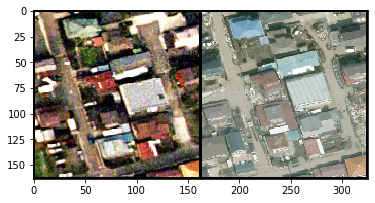

In [ ]:
# Show first pair
print(f"Target: {targets[0].item():.0f}")
show_pair(features[0])

### Model

#### Network architecture

In [ ]:


class LogisticRegression(nn.Module):
    """Logistic regression model"""

    def __init__(self) -> None:
        super().__init__()
        
        # Input tensor is of shape [batch_size, 6, 160, 160] 
       
        self.conv1 = nn.Conv2d(6, 16, kernel_size=5)
        self.conv2 = nn.Conv2d(16, 26, kernel_size=5)
        self.conv2_bn = nn.BatchNorm2d(26)
        self.conv3 = nn.Conv2d(26, 36, kernel_size=6)
        self.dropout= nn.Dropout(0.7)
        self.fc1 = nn.Linear(36*8*8,1)
        
        # Output of shape [batch_size, 1]

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv2_bn(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, 2)
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)
        x = x.flatten(start_dim=1)
        
        out = self.fc1(x)
        return out

        # Dimensionality along the CNN
        # 6,160,160 
        # conv2d (k=5) -> 16,156,156
        # max pool -> 16,78,78
        # conv2d (k=5) -> 26,74,74
        # max pool -> 26,37,37
        # conv2d (k=6)-> 36,32,32
        # max pool -> 36,16,16
        # max pool -> 36,8,8
        # flatten -> 1

      

In [ ]:
model = LogisticRegression()
model = model.to(device)
print(model)

#### Loss, optimizer, scheduler & number of epochs


In [ ]:
loss_fn = torch.nn.BCEWithLogitsLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')
epochs = 45

### Save, checkpoint and log

In [ ]:
# Path to which the model weights will be saved
timestr = time.strftime("%m%d-%H%M")
save_path = f"outputs/{timestr}"
Path(save_path).mkdir(parents=True, exist_ok=True)
save_path = os.path.join(save_path, "")
# Resume training from checkpoint 
checkpoint_path = None
# Log to tensorboard
writer = SummaryWriter()

#### TensorBoard within notebook 
It is possible to directly display a TensorBoard window within a notebook (instead of a separate browser tab). This is especially useful when using Colab.

In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [ ]:
# If a timed out message is displayed, wait a bit and run this cell again.
%tensorboard --logdir runs

### Model training

In [ ]:
# Launch training
trainer = Trainer(
        model=model,
        loss_fn=loss_fn,
        optimizer=optimizer,
        epochs=epochs,
        device=device,
        train_loader=train_loader,
        val_loader=val_loader,
        scheduler=scheduler,
        writer=writer,
        save_path=save_path,
        checkpoint_path=checkpoint_path,
        show_pbar=True
    )

In [ ]:
trainer.train()

### Model evaluation

In [ ]:
# Path to the model that needs to be evaluated (can be None to use current model)
eval_checkpoint_path = None

evaluator = Evaluator(
    model=model,
    device=device,
    loader=test_loader,
    checkpoint_path=eval_checkpoint_path
    )

In [ ]:
# If the data in evaluator has targets (e.g. train or val set), you can get the accuracy using evaluate()
print(test_loader.dataset.has_target)

In [ ]:
# Use predict() to get predictions (make sure the dataloader doesn't shuffle data)
predictions = evaluator.predict(threshold=0.5)

### .csv submission file generation




In [ ]:
# Use generate_submission() to get a correctly formatted CSV
submission_path = "outputs/submission.csv"
generate_submission(predictions, submission_path)